# Project Overview

Sports analytics are ubiquitous in Major League Baseball, the National Basketball Association and more recently the National Football League.  Sharp staffs and general managers are trying to extract every advantage and possible edge using teams of data crunchers to optimize personnel decisions and evaluate players.  However, these analytical techniques are strangely lacking in the realm of fantasy sports despite the ever-increasing payouts and growth in the billion-dollar industry.  Nowhere is metric-based fantasy analysis lacking more than the NFL and particularly dynasty fantasy football in which players keep the majority or all of their players year to year and try and identify promising rookies.

The ensuing analysis helps remedy this by applying frequently used machine learning algorithms to assist dynasty fantasy football owners.   Specifically, the analysis estimates the likelihood rookie wide receivers become useful starters (for fantasy football) within their first five years entering the NFL.  Currently, most dynasty player evaluation is based on qualitative inputs such as watching tape with minimal statistical analysis.  Even when there are some statistical measures present, they are often fairly basic and do not have the same predictive power modern machine learning tools can provide.  My hope is the ensuing analysis will serve as a useful complement to traditional player evaluation providing rewards to analytically minded owners and to help further the community’s understanding of what metrics augur NFL WR success.

## Problem Statement

Identifying productive young wide receivers in dynasty fantasy football is difficult given all the intricacies of modern NFL and NCAA passing offenses yet remains absolutely crucial in the context of dynasty fantasy football.   Wide receivers have lengthy careers and with the increasing prevalence of points per reception scoring – which gives wide receivers higher relative value – selecting the right wide receivers in rookie draft can have lasting positive effects when constructing dynasty rosters.
Criteria for NFL wide receiver “success” abound but in this context the analysis will target dynasty wide receivers (WR) notching at least one half point per reception top 24 WR finish within their first five years in the NFL as a “hit”. Not only do these WRs tend to provide multiple years of production, but they also tend to be the type of reliable producers week in week out which lead to more competitive teams in a game with highly volatile outcomes.

This study will use college production, NFL combine measurables, draft position in both dynasty and the NFL draft as well as some grading and statistics from Pro Football Focus to try and construct a model detailing the probability a player will become a productive fantasy starter.   The analytical techniques in the beginning will be fairly basic but evolve into successively more complicated machine learning techniques and approaches to increase the usefulness of the model.   	


## Metrics & Benchmark

The whole purpose of this analysis is to improve upon the numerous existing techniques for player evaluation.  There is no unanimous approach to player evaluation in NFL front offices and dynasty football players and sometimes participants don’t even have standardized approaches to scouting.  However, there are two data sources to get an idea of the consensus view on incoming rookies – the NFL draft and average draft position in dynasty football leagues available via the My Fantasy League website.   A player can derive significant information from using these two sources alone and basic regression techniques to forecast player success but there are further ways to increase their predictive capabilities using additional data and more sophisticated approaches.

The model will focus on two evaluation metrics compared to the benchmark to assess success:

1)	Accuracy: Measures the extent to which the model accurately designates success and failures scaled by the total number of predictions

2)	Area Under the Curve: An estimate of the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance.  This metric speaks to how well the model distinguishes between likely successes and failures and is superior in scrutinizing data where class imbalances exist 

The initial benchmark for the study is a simple logistic regression using unbalanced classes and scaled NFL and fantasy draft positioning.   Selecting a simple model with flaws as a benchmark was intentional to illustrate how balancing classes, adding features and using more sophisticated modelling techniques can improve the model’s predictive capabilities.


## Required Packages

This assignment will require a variety of different libraries including Numpy, Pandas, Matplotlib, Stats Model and several features in the Scikit Learn library.  I've done my best to annotate and group them below.

In [45]:
#Dataframe manipulation
import pandas as pd
import numpy as np

#Sklearn data pre-processing packages
from sklearn.impute import KNNImputer #for imputing missing data
from sklearn.preprocessing import MinMaxScaler #for standardizing data
from sklearn.model_selection import train_test_split #splitting the data into training/testing sets
from sklearn.utils import resample

#Evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

#Import supervised learning algorithms
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Visualization
from sklearn import tree
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Ignore deprecation warnings for presentation's sake
import warnings
warnings.filterwarnings('ignore')

## Data Inputs

Datasets for the problem are difficult to compile and require various source material: 

College Football Reference Receiving Statistics:  Contains receiving data for college WRs detailing college production. 
	
Dynasty League Football (DLF) Dynasty Avg. Draft Position Data: Represents the average rank dynasty football participants assigned to each player. As an example, the player most consistently being drafted at the #1 overall spot is considered the player with the most promising career. 

ESPN NFL Receiving Statistics:  This is to form the dependent. This will measure their success after selection and is the measure the dynasty fantasy football community most cares about.

Pro Football Focus Elite College Receiving Metrics: Advanced statistical metrics on performance which help supplement the college statistical data.

Pro Football Reference Combine Data: The NFL combine brings all incoming NFL players together to create standardized athletic tests measuring player speed, strength, agility and other measurables. In addition, this data also contains the player’s placement in the NFL draft which provides information on what professional evaluators think of the player (and differs from fantasy draft placement).

All of this data is available for free via their respective websites, with the exception of the Pro Football Focus data that requires a subscription.


In [46]:
#Loading CSV files with College Football Reference Receiving Statistics
college_stats_df = pd.read_csv("C:/Users/19712/Desktop/NFL Player Model/College Football Reference Receiving Statistics.csv")

#Loading CSV files with Avg DLF Dynasty Draft Position
ADP_df = pd.read_csv("C:/Users/19712/Desktop/NFL Player Model/Dynasty League Football (DLF) Dynasty Avg. Draft Position Data.csv")

# loading CSV files with consolidated ESPN NFL Receiving Statistics
dependent_df = pd.read_csv("C:/Users/19712/Desktop/NFL Player Model/ESPN NFL Receiving Statistics.csv")

#Loading CSV files with Pro Football Focus Elite College Receiving Metrics
pff_df = pd.read_csv("C:/Users/19712/Desktop/NFL Player Model/Pro Football Focus Elite College Receiving Metrics.csv")

#Loading CSV files with Pro Football Reference Combine Data
combine_df = pd.read_csv("C:/Users/19712/Desktop/NFL Player Model/Pro Football Reference Combine Data.csv")


## Data Pre-Processing

Compiling the data in of itself requires effort, however there will be some significant pre-processing and manipulation of the data itself before using machine learning techniques:

1)	Missing Data: Some of the data points are missing for legitimate reasons.  As an example, a player might not post combine measurables and Pro Football Focus doesn’t have full grading coverage and statistics for all eligible players.  Data imputation – filling in missing data using cues from existing data -  can help alleviate some of the gaps in the data.  As an example, if a player is missing 40 yard dash times at the combine but has stronger than normal yards after catch, avg yards per reception and a fast shittle time, it would suggest they also have a fast 40 yard dash time.

2)	Standardizing Data:  It’s important to standardize data prior to using machine learning techniques, otherwise, difference the units of measurement might distort the results. Additionally, it’s important to scale data appropriately so as to reduce outliers.  Most of this is done by using features which are fairly normally distributed (such as population combine data) or focusing on player production per game 

3)	Class Imbalances:  A class imbalance is when the target outcome is far more/ less common than the alternative (in this case the likelihood a top 24 fantasy WR).  Class imbalances can lead to issues training classifier algorithms because at certain thresholds, the algorithm might find it most accurate to simply classify all observations in one category or another without discriminating.   Two ways to circumvent this are to adjust the dataset to “balance” the two classes (upsampling/downsampling) or to use another criteria such as area under the curve when training models.  This study will use both techniques with more detail in the data pre-processing and evaluation section.


### Pre-Processing the ESPN Receiving Data

Creating the dependent for WRs recording a top 24 finish in ESPN half point per reception scoring involves: 

Step 1: Take receptions, yards, touchdowns and lost fumbles and convert them into a season-long score according to standard half PPR rules

Step 2: Take the season long score (from the above) for all WRs in ESPN’s scoring and then rank them grouped by season in descending fashion (highest score=1 and so on)

Step 3:  Create a filtering mechanism to flag WRs with less than 5 years of eligible experience in the NFL

Step 4:  Create a boolean column flagging if a WR notched a top 24 season for each season they were in the NFL

Step 5:  Take the maximum of the boolean flagged column for each WR (AKA if they had any season where they were a top 24 WR, return a 1)


In [47]:
#Step 1: Convert statistics to half-PPR scoring
dependent_df['SeasonScore'] = dependent_df['Receptions']*1/2 + dependent_df['Yards']*1/10 + dependent_df['Touchdowns']*6 + dependent_df['FumblesLost']*-2

#Step 2: Rank each WR finish by season
dependent_df['SeasonRank'] = dependent_df.groupby("Year")["SeasonScore"].rank("dense", ascending=False)

#Step 3: Create a filter for WRs with < 5 years NFL experience
dependent_df['YearChk'] = dependent_df['DraftYr']
dependent_df['EligibleRank'] = np.where((dependent_df['DraftYr']+5)>=dependent_df['Year'],dependent_df['SeasonRank'],np.nan)

#Step 4: Create a column boolean column flagging top 24 WR seasons
dependent_df['WRHit'] = np.where(dependent_df['EligibleRank']<=24,1,0)

#Step 5: Take the maximum flag for each WR
reduced_dependent_df = dependent_df[['Name', 'WRHit']]
grouped_df = reduced_dependent_df.groupby("Name")
maximums = grouped_df.max()
final_dependent_df = maximums.reset_index()

### Pre-Processing the College Statistical Data

Step 1: Take the data on the college conference, replace references to conferences which no longer exist (such as replacing Pac 10 with Pac 12) and then create a dictionary mapping the most prestigious conference vs. lower levels of competition. Finally assign conference designations based on the player’s most recent season prior to the draft (if they player switched conferences)

Step 2: Create some efficiency metrics based on college statistics (Yards per reception, Touchdown per reception, Yards per game, Touchdowns per game, Receptions per game)


In [48]:
#Isolate the college statistics dataframe to receiving statistics
college_stats_df = college_stats_df[['Player', 'Conf', 'G', 'Rec', 'Yds', 'TD', 'Year']]
college_stats_df['Conf'] = college_stats_df['Conf'].replace('Pac-10','Pac-12')

##Step 1: Establish college conference data
#Divide conferences into Power 5 and Non Power 5 for later one hot encoding
Conf_dict = {'ACC':1, 'Big 12':1, 'SEC':1, 'Big Ten': 1, 'Pac-12':1, 'Big East':1,  
             'CUSA': 0, 'MAC': 0, 'MWC': 0, 'Sun Belt': 0, 'American':0, 'WAC':0, 'Ind': 0}
college_stats_df['Power5'] = college_stats_df['Conf'].replace(Conf_dict)
college_stats_df['Name'] = college_stats_df['Player']

#Create a seperate dataframe for conference, a boolean for Big5
#Limit the df to most recent college season
college_stats_df['DraftYr'] = college_stats_df['Year']
college_conf_df = college_stats_df[['Name','Conf','Power5','DraftYr']]
college_conf_df['year_rank']  = college_conf_df.groupby('Name')['DraftYr'].rank(method='first',ascending=False)
college_conf_df = college_conf_df[college_conf_df.year_rank == 1]
college_conf_df = college_conf_df[['Name', 'Conf', 'Power5']]

##Step 2: Create basic efficiency statistics
#Create a sum of all college statistical data irrespective of college season
college_stats_sum = college_stats_df[['Name','G', 'Rec', 'Yds', 'TD']]
college_career_efficiency = college_stats_sum.groupby(['Name']).sum()

#Create some basic production efficiency statistics
college_career_efficiency['yardsperrecpt'] = college_career_efficiency['Yds']/college_career_efficiency['Rec']
college_career_efficiency['TDrate'] = college_career_efficiency['TD']/college_career_efficiency['Rec']
college_career_efficiency['yardspergame'] = college_career_efficiency['Yds']/college_career_efficiency['G']
college_career_efficiency['TDspergame'] = college_career_efficiency['TD']/college_career_efficiency['G']
college_career_efficiency['recpergame'] = college_career_efficiency['Rec']/college_career_efficiency['G']


### Pre-Processing the NFL Combine Data

Step 1:  Limit the receiving data solely to WRs and TEs

Step 2: Parse the data indicating draft position which is a string and extract the specific slot a player was selected in the NFL draft

Step 3: Take players who were undrafted and assign them the 224th draft slot instead of a null value (this treats undrafted players as if they were the last pick in the NFL draft)

Step 4:  Limit the dataframe to relevant variables

All other combine metrics are already floats or integers and do not require further conversion


In [49]:
#Step 1: Limit the dataframe to WRs and TEs
combine_df_WR = combine_df[(combine_df.Position =='WR') | (combine_df.Position=='TE')]

#Step 2: Parse the string data for the NFL draft position
combine_df_WR[['Team','Round', 'RoundPick', 'Year']] = combine_df_WR.DraftInfo.str.split("/",expand=True)
combine_df_WR['LenDraft'] = combine_df_WR['RoundPick'].str.len()
combine_df_WR['DraftSlot'] = combine_df_WR['RoundPick'].str.replace("pick","").str.replace("th","").str.replace("nd","").str.replace("rd","").str.replace("st","")

#Step 3: Assign undrafted free agents as having the last pick in the draft
combine_df_WR['DraftSlot'] = np.where(combine_df_WR['DraftSlot'].isna(), 32*7, combine_df_WR['DraftSlot'])
combine_df_WR['DraftSlot'] = pd.to_numeric(combine_df_WR['DraftSlot'])
 
#Step 4: Pare down the dataframe to focus on core combine metrics and draft position
combine_df_WR_pared = combine_df_WR[['Name', 'Height', 'Weight', '40yd', 'Vertical', 
                                     'Bench', 'Broad Jump', '3Cone','Shuttle','DraftSlot']]



### Pre-Process the Pro Football Focus Data

Step 1: Limit the PFF data to player seasons with at least 25 targets in a season to avoid providing stats on players with severely limited opportunities

Step 2: Aggregate all of the college player’s statistics for eligible seasons of 25 targets or more to create a dataset which reflects the players total college production

Step 3: Create a series of career efficiency metrics such as Yards per target, Catches per target, First downs per target, Turnovers (fumbles and credited receptions) per catch, Missed tackles per reception, Yards after catch per reception, Drops per target, Longest catch

Step 4: Create average grades for players over their full college career with a group by mean of all PFF season grades


In [50]:
#Step 1: Limit the PFF data to seasons with at least 25 targets
pff_df = pff_df[pff_df.targets > 25]

#Step 2: Aggregate the dataframe by player to create career production figures
pff_df_sum = pff_df[['Name', 'player_game_count', 'targets', 'receptions', 
                     'yards', 'touchdowns','yards_after_catch', 'longest',
                     'first_downs', 'drops', 'interceptions', 'fumbles', 'avoided_tackles',
                     'penalties', 'declined_penalties']]
pff_career_stats = pff_df_sum.groupby(['Name']).sum()
pff_career_efficiency = pff_career_stats

#Step 3: Creaete career efficiency metrics
pff_career_efficiency['yardspertgt'] = pff_career_efficiency['yards']/pff_career_efficiency['targets']
pff_career_efficiency['catchperct'] = pff_career_efficiency['receptions']/pff_career_efficiency['targets']
pff_career_efficiency['firstdownrate'] = pff_career_efficiency['first_downs']/pff_career_efficiency['receptions']
pff_career_efficiency['turnoverrate'] = (pff_career_efficiency['interceptions']+pff_career_efficiency['fumbles'])/pff_career_efficiency['receptions']
pff_career_efficiency['jukerate'] =  pff_career_efficiency['avoided_tackles']/pff_career_efficiency['receptions']
pff_career_efficiency['YACRate'] =  pff_career_efficiency['yards_after_catch']/pff_career_efficiency['receptions']
pff_career_efficiency['droprate'] = pff_career_efficiency['drops']/pff_career_efficiency['targets']
pff_career_efficiency = pff_career_efficiency[['longest', 'yardspertgt', 'catchperct', 'firstdownrate', 'turnoverrate','jukerate', 'YACRate', 'droprate']]

#Step 4: Create career avg PFF grades for qualifying seasons (seasons w/ >25 targets)
pff_career_avg = pff_df[['Name','grades_offense', 'grades_pass_route', 'grades_hands_drop',
                     'grades_hands_fumble', 'targeted_qb_rating']]
pff_career_avg = pff_career_avg.groupby(['Name']).mean()


### Merging the Dataframes

Step 1: Merge all of the inputs into a final dataframe for the final cleanup, scaling and imputation.

Step 2: Filter the data to include any WR who is already a success (even if they were drafted less than 5 years ago). This is because we already know their classification in this case.

Step 3: Remove players who were drafted in the last five years who have yet to post a top 24 WR season (because they could be a future success with development).

Step 4: Count the total number of nulls in the data and remove observations with a critical mass of nulls which simply don’t have enough data.



In [51]:
#Step 1: Merge all the dataframes together
#Use the dynasty draft avg. draft position as the basis for the data & left join from there
initial_ADP_df = ADP_df[ADP_df['Position']=='WR']
initial_ADP_df = initial_ADP_df[['Name','Pick','DraftYr']] 
final_data_df = initial_ADP_df.merge(combine_df_WR_pared, on='Name', how='left')
final_data_df = final_data_df.merge(final_dependent_df, on='Name', how='left')
final_data_df = final_data_df.merge(pff_career_efficiency, on='Name', how='left')
final_data_df = final_data_df.merge(pff_career_avg, on='Name', how='left')
final_data_df = final_data_df.merge(college_career_efficiency, on='Name', how='left')
final_data_df = final_data_df.merge(college_conf_df, on='Name', how='left')

#Step 2 & 3: Filter the data to keep WRs which have already hit and remove those that haven't played a full 5 years
final_data_df['WRHit'] = np.where(final_data_df['WRHit']==1,1,0)
final_data_df['Keep1'] = np.where(final_data_df['WRHit']==1,1,0)
final_data_df['Keep2'] = np.where(final_data_df['DraftYr']<2016,1,0)
final_data_df['Keep3'] = np.where(final_data_df['Keep1']==1,1,final_data_df['Keep2'])

#Step #4: Count the NaNs across columns and remove WR with < 20 data points
#Note, we are going to interpolate some measures to fill out the dataset
final_data_df['NAs'] = final_data_df.isnull().sum(axis=1)
final_data_df = final_data_df[final_data_df.NAs<=32]

#Reserve descriptive columns for after scaling and imputing data
include_df = final_data_df[['Keep3','DraftYr']]

#Remove unwanted helper columns
final_data_df = final_data_df.drop(['DraftYr', 'Keep1', 'Keep2', 'Keep3', 'NAs','Conf'], axis=1) 

#Make a list of player names as keys for dataframes after data manipulation
name_list = list(final_data_df['Name'])

#Create a dataframe where the names are the keys and drop the names column
final_data_df_numpy = final_data_df.to_numpy()
final_data_df_with_names = pd.DataFrame(final_data_df_numpy, columns = final_data_df.columns, index=name_list)
final_data_df = final_data_df_with_names.drop(['Name'], axis=1)

#Create a dataframe with descriptive data for after imputation
include_df_numpy = include_df.to_numpy()
include_df = pd.DataFrame(include_df_numpy, columns = include_df.columns, index=name_list)


### Standardizing the Data for Machine Learning

It’s important to standardize data prior to using machine learning techniques, otherwise, difference the units of measurement might distort the results. Additionally, it’s important to scale data appropriately so as to reduce outliers.  Most of this is done by using features which are fairly normally distributed (such as population combine data) or focusing on player production per game. Here we will apply min/max scaling to the dataset to standardize unit size.

In [52]:
#Apply Sklearn's MinMaxScaler prior to applying a K Means imputation algorithm
scaler = MinMaxScaler()

#Full dataset
scaler.fit(final_data_df)
final_data_df_kmeans = pd.DataFrame(scaler.transform(final_data_df), columns = final_data_df.columns, index=name_list)


### Handling Missing Data Via K Means Imputations

Some of the data points are missing for legitimate reasons.  As an example, a player might not post combine measurables and Pro Football Focus doesn’t have full grading coverage and statistics for all eligible players.  Data imputation – filling in missing data using cues from existing data -  can help alleviate some of the gaps in the data.  

K Means algorithms do require an input for the number of clusters to use which will require further investigation.  The below function helps minimize a loss function on the dependent data to help find the right # of clusters for imputation.

In [53]:
#This cell sets up a function used to determine the number of clusters for k means

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

#Next create a function to evalute k means errors

def optimize_k(data, target):
    errors = []
    for k in range(2, 30, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=data.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [54]:
#invoke the function optimize_k
optimize_k(data = final_data_df_kmeans, target='WRHit')

[{'K': 2, 'RMSE': 0.3668996928526714},
 {'K': 4, 'RMSE': 0.3668996928526714},
 {'K': 6, 'RMSE': 0.3922322702763681},
 {'K': 8, 'RMSE': 0.31008683647302115},
 {'K': 10, 'RMSE': 0.31008683647302115},
 {'K': 12, 'RMSE': 0.3668996928526714},
 {'K': 14, 'RMSE': 0.3668996928526714},
 {'K': 16, 'RMSE': 0.3396831102433787},
 {'K': 18, 'RMSE': 0.3668996928526714},
 {'K': 20, 'RMSE': 0.3668996928526714},
 {'K': 22, 'RMSE': 0.3922322702763681},
 {'K': 24, 'RMSE': 0.3922322702763681},
 {'K': 26, 'RMSE': 0.2773500981126146},
 {'K': 28, 'RMSE': 0.3668996928526714}]

In [55]:
#from the above, it appears ~20 clusters reduces the error rate

#Impute the full data
imputer = KNNImputer(n_neighbors=26)
imputed = imputer.fit_transform(final_data_df_kmeans)
final_data_df_kmeans = pd.DataFrame(imputed, columns=final_data_df_kmeans.columns, index=name_list)
final_data_df_kmeans['Power5'] = np.where(final_data_df_kmeans['Power5'] == 1,1,0)

Now that the data is imputed, it's important to limit the observations to WRs who have had sufficient time to produce a top 24 WR season.  This involves leaving some WRs in the data who have produced a top 24 finish in the league in less than 5 years and removing the WRs who have yet to hit that mark if they've yet to be in the leage that long.  The boolean column Keep3 flags such WRs so its important to merge the imputed data with the designation and then there will be some slicing of the dataframe for validation and inference later on using the draft year.

In [56]:
#Time to merge and the slice the data for later on
merge_df = pd.merge(final_data_df_kmeans, include_df, left_index=True, right_index=True)
final_data_df_kmeans = merge_df

#Create data for the 2020 class
final_data_df_2020 = final_data_df_kmeans[final_data_df_kmeans['DraftYr']==2020]

#Adjust the dataframe to remove ineligible WRs
final_data_df_kmeans = final_data_df_kmeans[final_data_df_kmeans['Keep3']==1]

#Create pre and post 2014 datasets for later validation
final_data_df_kmeans_pre2014 = final_data_df_kmeans[final_data_df_kmeans['DraftYr']<2014]
final_data_df_kmeans_post2014 = final_data_df_kmeans[final_data_df_kmeans['DraftYr']>=2014]

#Drop classification columns which are no longer required
final_data_df_kmeans = final_data_df_kmeans.drop(['Keep3', 'DraftYr'], axis=1)
final_data_df_kmeans_pre2014  = final_data_df_kmeans_pre2014.drop(['Keep3', 'DraftYr'], axis=1)
final_data_df_kmeans_post2014 = final_data_df_kmeans_post2014.drop(['Keep3', 'DraftYr'], axis=1)
final_data_df_2020 = final_data_df_2020.drop(['Keep3', 'DraftYr'], axis=1)


### Handling Class Imbalances

A class imbalance is when the target outcome is far more/less common than the alternative (in this case the likelihood a top 24 fantasy WR is less common than a bust).  Class imbalances can lead to issues training classifier algorithms because at certain thresholds, the algorithm might find it most accurate to simply classify all observations in one category or another without discriminating.   Two ways to circumvent this are to adjust the dataset to “balance” the two classes (upsampling/downsampling) or to use another criteria such as area under the curve when training models.  This study will use both techniques with more detail in the data pre-processing and evaluation section.

The first step with upsampling is to look at the distribution of the predicted variables prior to resampling the data.

In [57]:
#Let's look at the class distribution
final_data_df_kmeans['WRHit'].value_counts()

0.0    110
1.0     53
Name: WRHit, dtype: int64

Here you can see that in the past, roughly 1/3 of drafted WRs post a top 24 season whereas 2/3 register failure.  The below code will use sklearn's resample utility to balance the classes by taking the existing successful WRs and increasing the frequency so they occur as often as failures.  That way, there is an equal probability successes and failures are part of the training and testing process.

In [58]:
#Looking at the class distribution it's approximately 1/3 success 2/3 failure.  We must rebalance the classes

# Separate WR successes and failures as classes
final_data_df_kmeans_hit = final_data_df_kmeans[final_data_df_kmeans.WRHit==1]
final_data_df_kmeans_bust = final_data_df_kmeans[final_data_df_kmeans.WRHit==0]

# Upsample success so they are occur with the same frequency as failures
final_data_df_kmeans_hit_upsample = resample(final_data_df_kmeans_hit, 
                                 replace=True,     # sample with replacement
                                 n_samples=110,    # to match majority class
                                 random_state=123) # reproducible results

# Combine upsampled success class with the failures
final_data_df_kmeans_upsample = pd.concat([final_data_df_kmeans_bust, final_data_df_kmeans_hit_upsample])
 
# Display new class counts
final_data_df_kmeans_upsample.WRHit.value_counts()


1.0    110
0.0    110
Name: WRHit, dtype: int64

As you can see from the new value counts, WR successes are now as prevalent as failures in the dataframe thereby completing the upsample procedure.

### Visualization of WR Success by Draft Position

Player draft position can be fairly predictive itself and while everyone has their own views on players most dynasty players take some cues from the NFL and dynasty community consensus.  But how accurate is it?   Pretty accurate as it turns out.  If you were to take a random cue on player selection it does appear that NFL and the dynasty fantasy football hive mind do a fairly good job of ordering prospects, particularly the top prospects.  It does make sense to weight the consensus in the model albeit as one of several factors that drive player selection.


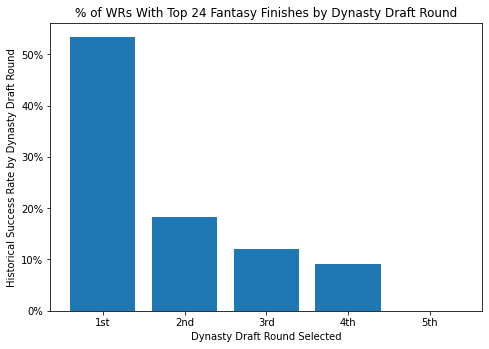

<Figure size 3600x288 with 0 Axes>

In [59]:
#Providing avg. success rates by dynasty draft avg. draft position

#Pull in the raw data
avg_draft_success = final_data_df[['WRHit', 'Pick']]
avg_draft_success['WRHit'] = pd.to_numeric(avg_draft_success['WRHit'])
 
#Create rounds based on draft placement (each round has 12 slots typically)
avg_draft_success['Groupings'] = np.where(final_data_df['Pick']<= 12, 1,
                                 np.where(final_data_df['Pick']<= 24, 2,
                                 np.where(final_data_df['Pick']<= 36, 3,
                                 np.where(final_data_df['Pick']<= 48, 4, 5
                                         ))))


avg_draft_success = avg_draft_success.groupby(['Groupings']).mean()
plt_plot_data = avg_draft_success['WRHit']*100

#Create a bar chart for the % of successful draft picks per round grouping
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
draft_position = ['1st', '2nd', '3rd', '4th', '5th']
hits = plt_plot_data
plt.ylabel("Historical Success Rate by Dynasty Draft Round")
plt.xlabel("Dynasty Draft Round Selected")
plt.title("% of WRs With Top 24 Fantasy Finishes by Dynasty Draft Round")
plt.figure(figsize=(50,4))
ax.bar(draft_position, hits)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

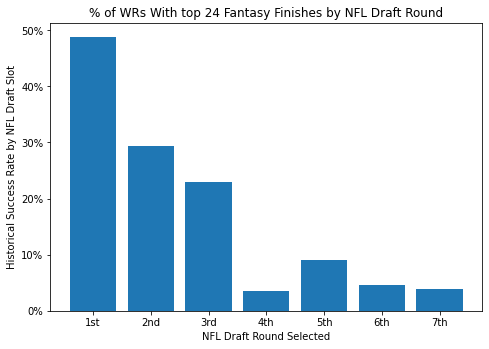

<Figure size 3600x288 with 0 Axes>

In [60]:
#Providing avg. success rates by NFL draft position

#Pull in raw data
avg_draft_success = final_data_df[['WRHit', 'DraftSlot']]
avg_draft_success['WRHit'] = pd.to_numeric(avg_draft_success['WRHit'])
 
#Create NFL draft groupings (each round has 32 picks excluding compensatory picks which vary year to year)
avg_draft_success['Groupings'] = np.where(final_data_df['DraftSlot']<= 32, 1,
                                 np.where(final_data_df['DraftSlot']<= 32*2, 2,
                                 np.where(final_data_df['DraftSlot']<= 32*3, 3,
                                 np.where(final_data_df['DraftSlot']<= 32*4, 4, 
                                 np.where(final_data_df['DraftSlot']<= 32*5, 5,
                                 np.where(final_data_df['DraftSlot']<= 32*6, 6,
                                          7
                                         ))))))


avg_draft_success = avg_draft_success.groupby(['Groupings']).mean()
plt_plot_data = avg_draft_success['WRHit']*100
plt_plot_data

#Create a bar chart for the % of successful draft picks per round grouping
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
draft_position = ['1st', '2nd', '3rd', '4th', '5th','6th', '7th']
hits = plt_plot_data
plt.ylabel("Historical Success Rate by NFL Draft Slot")
plt.xlabel("NFL Draft Round Selected")
plt.title("% of WRs With top 24 Fantasy Finishes by NFL Draft Round")
plt.figure(figsize=(50,4))
ax.bar(draft_position, hits)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

## Algorithms and Techniques

This analysis will use a variety of algorithms to evaluate the data at hand starting from very basic linear models to more sophisticated approaches.  The analysis will start with logistic regression models to provide some details on the coefficients of the various inputs, then move to simple decision tree classifiers to better understand the most crucial determinants of WR production before moving on to bagging, boosting and ensemble techniques to try and increase the model’s predictiveness vs. a simpler decision tree classifier.  The rationales for each of the different algorithms is as follows:

### Logistic Regression (Stats Model & Scikit Learn Logistic Regression)

Pros:  This is the only model with coefficients which can be used for analysis as well as providing information on the statistical significance of the different variables.  It is also the easiest algorithm for many people who are less familiar with machine learning to understand.

Cons:  Despite these appealing characteristics for presentation, the underlying assumption of linearity and the presence of multi-collinearity result in lower accuracy than models which allow for more variance.

### Decision Tree Classifier (Scikit Learning Decision Tree Classifier)

Pros:  Decision tree classifiers allow for more non-linear interpretations of the data which are unavailable in a logistic regression model.  Further, the decision tree nodes focus on how to partition the data in a manner with the highest node purity, giving insights into crucial rules to follow when evaluating WR success or failure.

Cons:  Decision tree classifiers can over-fit the data so it’s crucial to take steps to ensure that the model performs as well in testing as well as training.  Further, there are several inputs which will require tuning to determine the optimal way to setup the classifier itself.

### Decision Tree Bagging Classifier (Sklearn Bagging Classifier)

Pros:  Bagging stands for bootstrap aggregation and is akin to create several different smaller decision trees and using their inputs to come to a consensus on the data.  They are useful to avoid overfitting because they lower variance and provide a plurality of outputs.

Cons: The lower variance of using a bagging classifier might lead to a less accurate model than an approach with more variance.  Additionally, the model might be difficult to interpret using visualization tools with the same ease as an individual decision tree classifier given its using so many model inputs.

### Decision Tree Random Forest Classifier (Scikit Learn Random Forest Classifier)

Pros:  Random forest classifiers are a subset of bagging classifiers which also take random samples of the data and construct models but also take an extra step where they randomize the input features.  By doing so they reduce variance even more than a bagging classifier due to the exclusion of specific features and can help avoid overfitting or having a few dominant features drive all the decisions for the model.

Cons: The lower variance of using a random forest classifier might lead to a less accurate model than an approach with more variance.  Further, the omission of specific features might result in a large portion of the input models missing key features which assist in segmenting the data.  Additionally, the model might be difficult to interpret using visualization tools with the same ease as an individual decision tree classifier given its using so many model inputs.

### Decision Tree Boosting Classifier (GradientBoostingClassifier)

Pros: Gradient boosting classifiers are a group of machine learning algorithms which combine multiple decision tree classifiers together to create a stronger predictive model via iteratively incorporating new decision trees which reduce a loss function.  The iterative boosting process typically results in very accurate models especially because gradient boosting trains on hard to classify residuals compared to adaptive boosting which will train on a newly sampled distribution.

Cons: Gradient boosting can be prone to overfitting as it can fixate on outliers too much.  Additionally, the computation time and tuning can be quite intensive in nature and the network of decision trees can be difficult to interpret.


## Implementation

This study is designed to model several machine learning techniques and then settle into the model which has the highest area under the curve on the testing set as the final solution to the problem.  The study will cover the following test scenarios to illustrate progressively more effective models for the problem:

#### Test 1: Logistic Regression with NFL draft & fantasy football draft position,
This model is designed to serve as the initial benchmark for success. While this may seem naive, recall NFL and dynasty draft position represent the consensus views of many practitioners with different modalities for player selection.

#### Test 2: Logistic Regression with all possible feature data
This model is intended to illustrate the predictiveness using all available features in a logistic regression.  While this will improve the AUC because of the increase in features, it will likely be less predictive than other approaches with less variance.

#### Test 3: Decision Tree Classifier with default inputs
A decision tree classifier serves three purposes 1) to break the assumption of linearity 2) to establish a baseline for the predictiveness of a naïve decision tree classifier prior to tuning and 3) to provide illustrations for decision tree nodes.

#### Test 4: Bagging Classifier with optimized inputs
Bagging models are for exploring if several optimized decision tree classifiers provide a more effective solution than just one tree (and alternatives).

#### Test 5: Random Forest Classifier with optimized inputs
The random forest model is in the analysis to explore if an optimized random forest classifier provides a more effective solution to the final problem.

#### Test 6: Gradient Boosting Classifier with optimized inputs
Finally, the gradient boosting classifier is for investigating if optimized gradient boosting classifier provides a more effective solution to the final problem.

Before implementing any of these models, however, it's neccessary to prepare the dataframes with x and y values as well as split the model into testing and training sets.  

In [128]:
# Prepare two sets of x values using the upsampled data
x_values_draft_only = final_data_df_kmeans_upsample[['Pick','DraftSlot']]
x_values = final_data_df_kmeans_upsample.drop(['WRHit'], axis=1)

#Prepare the y values using the upsampled data
y_values = final_data_df_kmeans_upsample['WRHit']

#Now let's create test and training data with upsampling techniques for unbalanced classes - draft only
x_train_draft, x_test_draft, y_train_draft, y_test_draft = train_test_split(x_values_draft_only, y_values, test_size=0.40, random_state=30)

#Now let's create test and training data with upsampling techniques for unbalanced classes - all data
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.4, random_state=30)



### Setting up the benchmark

As indicated, the benchmark for improving model accuracy will be a logistic regression using both NFL and dynasty draft position which is setup below.  Recall, the study will be using area under the curve as the primary way to analyze across the models but will also have precision as a supplemental measure.


In [129]:
#Setup a logistic regression model
logmodel1 = LogisticRegression()
logmodel1.fit(x_train_draft, y_train_draft)

#Compute model accuracy
y_pred1 = logmodel1.predict(x_test_draft)
y_pred2 = logmodel1.predict_proba(x_test_draft)[:,1]
accuracy = logmodel1.score(x_test_draft, y_test_draft)

#Return the model accuracy & AUC measures
print('The benchmark logistic model accuracy is: ' + str(accuracy *100) + '%')
print("The benchmark logistic model AUC scores computed using 5-fold cross-validation: {}".format(metrics.roc_auc_score(y_test_draft, y_pred1)))


The benchmark logistic model accuracy is: 68.18181818181817%
The benchmark logistic model AUC scores computed using 5-fold cross-validation: 0.6837209302325581


#### Using Other Algorithms to Increase Predictive Capability

The initial model using draft positioning has some predictive capability but there is room for further improvement.  The next step of this project is to test if other machine learning algorithms are capable of providing modeling techniques which improve area under the curve.

In [130]:
##Test 2: Logistic Regression with all possible feature data
#Setup a logistic regression model
logmodel2 = LogisticRegression()
logmodel2.fit(x_train, y_train)

#Compute model accuracy
y_pred1 = logmodel2.predict(x_test)
y_pred2 = logmodel2.predict_proba(x_test)[:,1]
accuracy = logmodel2.score(x_test, y_test)

#Return the model accuracy & AUC measures
print('Results for Test #2: Logistic model with all possible features')
print('The accuracy is: ' + str(accuracy *100) + '%')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))


##Test 3: Decision Tree Classifier with default inputs
#Setup a decision tree classifier
modeltree = tree.DecisionTreeClassifier()
modeltree.fit(x_train, y_train)

#Compute model accuracy
y_pred1 = modeltree.predict(x_test)
y_pred2 = modeltree.predict_proba(x_test)[:,1]
accuracy = modeltree.score(x_test, y_test)

#Print out model results
print('')
print('Results for Test #3: Default decision tree classifier')
print('The accuracy is: ' + str(accuracy *100) + '%')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))


##Test 4: Bagging Classifier with optimized inputs
#Setup a logistic regression model
dtc = DecisionTreeClassifier(criterion="gini")
modelbagging = BaggingClassifier(base_estimator=dtc)
modelbagging.fit(x_train, y_train)

#Compute model accuracy
y_pred1 = modelbagging.predict(x_test)
accuracy = modelbagging.score(x_test, y_test)

#Print out model results
print('')
print('Results for Test #4: Bagging classifier')
print('The accuracy is: ' + str(accuracy *100) + '%')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))

##Test 5: Random Forest Classifier with default inputs
#Setup a logistic regression model
modelrandomforest = RandomForestClassifier()
modelrandomforest.fit(x_train, y_train)

#Compute model accuracy
y_pred1 = modelrandomforest.predict(x_test)
accuracy = modelrandomforest.score(x_test, y_test)

#Print out model results
print('')
print('Results for Test #5: Random forest classifier')
print('The accuracy is: ' + str(accuracy *100) + '%')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))

##Test 6: Gradient Boosting Classifier with optimized inputs
modelGBC = GradientBoostingClassifier()
modelGBC.fit(x_train, y_train)
    
#Compute model accuracy
y_pred1 = modelGBC.predict(x_test)
accuracy = modelGBC.score(x_test, y_test)

#Print out model results
print('')
print('Results for Test #6: Gradient Boosting Classifier')
print('The accuracy is: ' + str(accuracy *100) + '%')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))


Results for Test #2: Logistic model with all possible features
The accuracy is: 79.54545454545455%
AUC score is: 0.7963824289405685

Results for Test #3: Default decision tree classifier
The accuracy is: 84.0909090909091%
AUC score is: 0.842377260981912

Results for Test #4: Bagging classifier
The accuracy is: 84.0909090909091%
AUC score is: 0.842377260981912

Results for Test #5: Random forest classifier
The accuracy is: 86.36363636363636%
AUC score is: 0.8645994832041342

Results for Test #6: Gradient Boosting Classifier
The accuracy is: 86.36363636363636%
AUC score is: 0.8645994832041342


### Base Model Results

It appears as if all of the models outperform the benchmark model with varying degrees of success.  Even though the logistic model is in striking distance of other AUCs, more advanced algorithms will probably have much higher AUCs with some tuning and improvement.

## Model Refinement

The initial accuracy and area under the curve results were fairly strong with the default settings but can be improved with further tuning.  The tuning / refinement process will take place in a few steps.   To do so, I created a function which can iteratively feed the models different inputs, run the model and produce a new AUC for each to pinpoint areas which improve accuracy.

Base Decision Tree Classifier:  Tuning some of the initial decision tree classifier’s major inputs such as max depth, minimum sample leafs and max features indicated potential improvements to the decision tree classifier.  Altering the max depth of the decision tree classifier to a depth of 6 and min sample leafs to 10% resulted in an improvement to the first model from an AUC of  91.8% to an AUC of 93.2%.

Bagging Classifier:  Tuning some of the bagging classifier’s major inputs such as the max features and number of estimators indicated potential improvements to the bagging classifier.  Altering the max features to 30 and number of estimators for the classifier to 80 resulted in an improvement to the first model from an AUC of  90.6% to an AUC of 91.8%.

Random Forest Classifier: Tuning some of the random forest classifier’s major inputs such as the number of estimators and max depth indicated potential improvements to the random forest classifier.  Altering the max depth to 6 and number of estimators for the classifier to 400 resulted in an improvement to the first model from an AUC of  88.3% to an AUC of 91.8%.

Gradient Boosting Classifier: Tuning some of the gradient boosting classifier’s major inputs such as the learning rate, number of estimators and max depth indicated potential improvements to the gradient boosting classifier.  Altering the max depth to 2, the number of estimators to 500 and a learning rate of .55 resulted in an improvement to the first model from an AUC of  88.3% to an AUC of 95.4%.


### Tuning the Original Decision Tree Classifier

In [136]:
##Tuning the decision tree classifier max depth
i = 1
while i <= 10:
    model = DecisionTreeClassifier(max_depth= i)
    model.fit(x_train, y_train)   
    
    #Calculate training score
    y_pred1 = model.predict(x_test)   
    print('Max Depth: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 1

Max Depth: 1
AUC score is: 0.8186046511627908
Max Depth: 2
AUC score is: 0.8863049095607234
Max Depth: 3
AUC score is: 0.8645994832041342
Max Depth: 4
AUC score is: 0.8534883720930232
Max Depth: 5
AUC score is: 0.8868217054263566
Max Depth: 6
AUC score is: 0.8868217054263566
Max Depth: 7
AUC score is: 0.8868217054263566
Max Depth: 8
AUC score is: 0.8868217054263566
Max Depth: 9
AUC score is: 0.842377260981912
Max Depth: 10
AUC score is: 0.8529715762273902


In [137]:
##Tuning the decision tree classifier min sample split
i = .05
while i <= .5:
    model = DecisionTreeClassifier(max_depth=6, min_weight_fraction_leaf= i)
    model.fit(x_train, y_train)   
    
    #Calculate training score
    y_pred1 = model.predict(x_test)   
    print('Min_Samples_Leaf: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += .025

Min_Samples_Leaf: 0.05
AUC score is: 0.8302325581395349
Min_Samples_Leaf: 0.07500000000000001
AUC score is: 0.8201550387596899
Min_Samples_Leaf: 0.1
AUC score is: 0.8201550387596899
Min_Samples_Leaf: 0.125
AUC score is: 0.8201550387596899
Min_Samples_Leaf: 0.15
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.175
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.19999999999999998
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.22499999999999998
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.24999999999999997
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.27499999999999997
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.3
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.325
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.35000000000000003
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.37500000000000006
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.4000000000000001
AUC score is: 0.8186046511627908
Min_Samples_Leaf: 0.4250000000000001
AUC

In [138]:
##Tuning the decision tree classifier min sample split
i = 1
while i <= 30:
    model = DecisionTreeClassifier(max_depth=6, max_features= i)
    model.fit(x_train, y_train)   
    
    #Calculate training score
    y_pred1 = model.predict(x_test)   
    print('Max features: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 1

    

Max features: 1
AUC score is: 0.7963824289405685
Max features: 2
AUC score is: 0.8201550387596899
Max features: 3
AUC score is: 0.8666666666666667
Max features: 4
AUC score is: 0.8640826873385014
Max features: 5
AUC score is: 0.8757105943152454
Max features: 6
AUC score is: 0.8534883720930232
Max features: 7
AUC score is: 0.9333333333333333
Max features: 8
AUC score is: 0.8863049095607234
Max features: 9
AUC score is: 0.7968992248062016
Max features: 10
AUC score is: 0.7868217054263567
Max features: 11
AUC score is: 0.8651162790697675
Max features: 12
AUC score is: 0.8777777777777778
Max features: 13
AUC score is: 0.8666666666666667
Max features: 14
AUC score is: 0.8661498708010336
Max features: 15
AUC score is: 0.9111111111111111
Max features: 16
AUC score is: 0.8201550387596899
Max features: 17
AUC score is: 0.842377260981912
Max features: 18
AUC score is: 0.8661498708010336
Max features: 19
AUC score is: 0.8868217054263566
Max features: 20
AUC score is: 0.7857881136950905
Max featur

### Tuned Decision Tree Classifier

It appears that there are a few steps to improve the model and avoid overfitting such as limiting the max depth of the tree to 6 and max features to 15.  I avoided imposing a minimum weight fraction leaf as there doesnt appear to be a benefit.

In [139]:
#Decision Tree Classifier with tuned inputs
#Setup a decision tree classifier
modeltreetuned = tree.DecisionTreeClassifier(max_depth=6, max_features=15)
modeltreetuned.fit(x_train, y_train)

#Compute model accuracy
y_pred1 = modeltreetuned.predict(x_test)
accuracy = modeltreetuned.score(x_test, y_test)

#Print out model results
print('')
print('Results for the tuned decision tree classifier')
print('The accuracy is: ' + str(accuracy *100) + '%')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))


Results for the tuned decision tree classifier
The accuracy is: 87.5%
AUC score is: 0.8757105943152454


### Tuning the Bagging Classifier

In [141]:
##Tuning the bagging classifier max features

i = 2
while i <= 30:
    modelbaggingtuned = BaggingClassifier(max_features=i)
    modelbaggingtuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelbaggingtuned.predict(x_test)   
    print('Max features: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 2

Max features: 2
AUC score is: 0.7741602067183463
Max features: 4
AUC score is: 0.9201550387596898
Max features: 6
AUC score is: 0.9
Max features: 8
AUC score is: 0.840826873385013
Max features: 10
AUC score is: 0.9222222222222223
Max features: 12
AUC score is: 0.8757105943152454
Max features: 14
AUC score is: 0.8534883720930232
Max features: 16
AUC score is: 0.8645994832041342
Max features: 18
AUC score is: 0.8757105943152454
Max features: 20
AUC score is: 0.8868217054263566
Max features: 22
AUC score is: 0.8757105943152454
Max features: 24
AUC score is: 0.9
Max features: 26
AUC score is: 0.842377260981912
Max features: 28
AUC score is: 0.8645994832041342
Max features: 30
AUC score is: 0.842377260981912


In [142]:
##Tuning the bagging classifier number of estimators

i = 5
while i <= 100:
    modelbaggingtuned = BaggingClassifier(max_features =10, n_estimators=i)
    modelbaggingtuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelbaggingtuned.predict(x_test)   
    print('Number of Estimators: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 5

Number of Estimators: 5
AUC score is: 0.8307493540051679
Number of Estimators: 10
AUC score is: 0.9
Number of Estimators: 15
AUC score is: 0.9333333333333333
Number of Estimators: 20
AUC score is: 0.9
Number of Estimators: 25
AUC score is: 0.9
Number of Estimators: 30
AUC score is: 0.9222222222222223
Number of Estimators: 35
AUC score is: 0.8534883720930232
Number of Estimators: 40
AUC score is: 0.8868217054263566
Number of Estimators: 45
AUC score is: 0.842377260981912
Number of Estimators: 50
AUC score is: 0.8534883720930232
Number of Estimators: 55
AUC score is: 0.8534883720930232
Number of Estimators: 60
AUC score is: 0.8757105943152454
Number of Estimators: 65
AUC score is: 0.8868217054263566
Number of Estimators: 70
AUC score is: 0.8534883720930232
Number of Estimators: 75
AUC score is: 0.8757105943152454
Number of Estimators: 80
AUC score is: 0.8645994832041342
Number of Estimators: 85
AUC score is: 0.9
Number of Estimators: 90
AUC score is: 0.8757105943152454
Number of Estimato

### Tuned Bagging Classifier

It appears from the above that tuning the bagging classifier along the number of features and the number of estimators does little to improve the results.

In [146]:
modelbaggingtuned = BaggingClassifier(max_features =10)
modelbaggingtuned.fit(x_train, y_train)

#Calculate training score
y_pred1 = modelbaggingtuned.predict(x_test)   
print('Tuned Bagging Classifier Results')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))

Tuned Bagging Classifier Results
AUC score is: 0.9444444444444444


### Tuning a Random Forest Classifier

In [147]:
##Tuning the random forest classifier number of trees

i = 20
while i <= 400:
    modelrandomforesttuned = RandomForestClassifier(n_estimators= i)
    modelrandomforesttuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelrandomforesttuned.predict(x_test)   
    print('Number of Trees: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 20


Number of Trees: 20
AUC score is: 0.9222222222222223
Number of Trees: 40
AUC score is: 0.8868217054263566
Number of Trees: 60
AUC score is: 0.8645994832041342
Number of Trees: 80
AUC score is: 0.8888888888888888
Number of Trees: 100
AUC score is: 0.9222222222222223
Number of Trees: 120
AUC score is: 0.8645994832041342
Number of Trees: 140
AUC score is: 0.9111111111111111
Number of Trees: 160
AUC score is: 0.8645994832041342
Number of Trees: 180
AUC score is: 0.9222222222222223
Number of Trees: 200
AUC score is: 0.8645994832041342
Number of Trees: 220
AUC score is: 0.8868217054263566
Number of Trees: 240
AUC score is: 0.8645994832041342
Number of Trees: 260
AUC score is: 0.8534883720930232
Number of Trees: 280
AUC score is: 0.8868217054263566
Number of Trees: 300
AUC score is: 0.8645994832041342
Number of Trees: 320
AUC score is: 0.8757105943152454
Number of Trees: 340
AUC score is: 0.8534883720930232
Number of Trees: 360
AUC score is: 0.8645994832041342
Number of Trees: 380
AUC score i

In [148]:
##Tuning the random forest classifier max depth

i = 1
while i <= 20:
    modelrandomforesttuned = RandomForestClassifier(max_depth= i)
    modelrandomforesttuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelrandomforesttuned.predict(x_test)   
    print('Max Depth: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 1


Max Depth: 1
AUC score is: 0.7963824289405685
Max Depth: 2
AUC score is: 0.8418604651162791
Max Depth: 3
AUC score is: 0.8645994832041342
Max Depth: 4
AUC score is: 0.8534883720930232
Max Depth: 5
AUC score is: 0.8534883720930232
Max Depth: 6
AUC score is: 0.8645994832041342
Max Depth: 7
AUC score is: 0.8645994832041342
Max Depth: 8
AUC score is: 0.8645994832041342
Max Depth: 9
AUC score is: 0.8645994832041342
Max Depth: 10
AUC score is: 0.8757105943152454
Max Depth: 11
AUC score is: 0.8645994832041342
Max Depth: 12
AUC score is: 0.8645994832041342
Max Depth: 13
AUC score is: 0.9111111111111111
Max Depth: 14
AUC score is: 0.8645994832041342
Max Depth: 15
AUC score is: 0.9222222222222223
Max Depth: 16
AUC score is: 0.8868217054263566
Max Depth: 17
AUC score is: 0.8757105943152454
Max Depth: 18
AUC score is: 0.8645994832041342
Max Depth: 19
AUC score is: 0.8534883720930232
Max Depth: 20
AUC score is: 0.8645994832041342


In [149]:
##Tuning the random forest classifier min samples splits

i = .025
while i <= .25:
    modelrandomforesttuned = RandomForestClassifier(max_depth = 15, min_samples_split= i)
    modelrandomforesttuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelrandomforesttuned.predict(x_test)   
    print('Min Samples Split: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += .025


Min Samples Split: 0.025
AUC score is: 0.8645994832041342
Min Samples Split: 0.05
AUC score is: 0.8645994832041342
Min Samples Split: 0.07500000000000001
AUC score is: 0.9
Min Samples Split: 0.1
AUC score is: 0.9111111111111111
Min Samples Split: 0.125
AUC score is: 0.8645994832041342
Min Samples Split: 0.15
AUC score is: 0.8645994832041342
Min Samples Split: 0.175
AUC score is: 0.8534883720930232
Min Samples Split: 0.19999999999999998
AUC score is: 0.8645994832041342
Min Samples Split: 0.22499999999999998
AUC score is: 0.8312661498708009
Min Samples Split: 0.24999999999999997
AUC score is: 0.8888888888888888


### Tuned Random Forest Classifier

It appears possible that manipulating the maximum depth (15) is the only of the three parameters which improves model AUC.

In [150]:
modelrandomforesttuned = RandomForestClassifier(max_depth = 15)
modelrandomforesttuned.fit(x_train, y_train)

#Calculate training score
y_pred1 = modelrandomforesttuned.predict(x_test)   
print('Random Forest Classifier Results')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))

Random Forest Classifier Results
AUC score is: 0.9222222222222223


Tuning these variables increases the AUC of the random forest classifier.

### Tuning the Gradient Boosting Classifier

In [151]:
## Tuning the Gradient Boosting Classifier learning rate
i = .025
while i <= .5:
    modelGBCtuned = GradientBoostingClassifier(learning_rate = i)
    modelGBCtuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelGBCtuned.predict(x_test)   
    print('Learning Rate: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += .025

Learning Rate: 0.025
AUC score is: 0.8645994832041342
Learning Rate: 0.05
AUC score is: 0.8645994832041342
Learning Rate: 0.07500000000000001
AUC score is: 0.8645994832041342
Learning Rate: 0.1
AUC score is: 0.8645994832041342
Learning Rate: 0.125
AUC score is: 0.8645994832041342
Learning Rate: 0.15
AUC score is: 0.8534883720930232
Learning Rate: 0.175
AUC score is: 0.8534883720930232
Learning Rate: 0.19999999999999998
AUC score is: 0.8534883720930232
Learning Rate: 0.22499999999999998
AUC score is: 0.8534883720930232
Learning Rate: 0.24999999999999997
AUC score is: 0.8534883720930232
Learning Rate: 0.27499999999999997
AUC score is: 0.8534883720930232
Learning Rate: 0.3
AUC score is: 0.8645994832041342
Learning Rate: 0.325
AUC score is: 0.8757105943152454
Learning Rate: 0.35000000000000003
AUC score is: 0.8534883720930232
Learning Rate: 0.37500000000000006
AUC score is: 0.8645994832041342
Learning Rate: 0.4000000000000001
AUC score is: 0.8534883720930232
Learning Rate: 0.42500000000000

In [152]:
## Tuning the Gradient Boosting Classifier # of estimators
i = 50
while i <= 500:
    modelGBCtuned = GradientBoostingClassifier(n_estimators = i)
    modelGBCtuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelGBCtuned.predict(x_test)   
    print('Number of Estimators: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 50

Number of Estimators: 50
AUC score is: 0.8645994832041342
Number of Estimators: 100
AUC score is: 0.8645994832041342
Number of Estimators: 150
AUC score is: 0.8645994832041342
Number of Estimators: 200
AUC score is: 0.8645994832041342
Number of Estimators: 250
AUC score is: 0.8645994832041342
Number of Estimators: 300
AUC score is: 0.8645994832041342
Number of Estimators: 350
AUC score is: 0.8645994832041342
Number of Estimators: 400
AUC score is: 0.8645994832041342
Number of Estimators: 450
AUC score is: 0.8645994832041342
Number of Estimators: 500
AUC score is: 0.8645994832041342


In [153]:
## Tuning the Gradient Boosting Classifier learning rate
i = 1
while i <= 20:
    modelGBCtuned = GradientBoostingClassifier(max_depth = i)
    modelGBCtuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelGBCtuned.predict(x_test)   
    print('Max Depth: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 1

Max Depth: 1
AUC score is: 0.8757105943152454
Max Depth: 2
AUC score is: 0.8534883720930232
Max Depth: 3
AUC score is: 0.8645994832041342
Max Depth: 4
AUC score is: 0.842377260981912
Max Depth: 5
AUC score is: 0.8645994832041342
Max Depth: 6
AUC score is: 0.8757105943152454
Max Depth: 7
AUC score is: 0.8534883720930232
Max Depth: 8
AUC score is: 0.8534883720930232
Max Depth: 9
AUC score is: 0.8534883720930232
Max Depth: 10
AUC score is: 0.8534883720930232
Max Depth: 11
AUC score is: 0.8534883720930232
Max Depth: 12
AUC score is: 0.8534883720930232
Max Depth: 13
AUC score is: 0.8534883720930232
Max Depth: 14
AUC score is: 0.8534883720930232
Max Depth: 15
AUC score is: 0.8534883720930232
Max Depth: 16
AUC score is: 0.8534883720930232
Max Depth: 17
AUC score is: 0.8534883720930232
Max Depth: 18
AUC score is: 0.8534883720930232
Max Depth: 19
AUC score is: 0.8534883720930232
Max Depth: 20
AUC score is: 0.8534883720930232


In [155]:
## Tuning the Gradient Boosting Classifier max features

i = 1
while i <= 33:
    modelGBCtuned = GradientBoostingClassifier(max_depth = 6,max_features = i)
    modelGBCtuned.fit(x_train, y_train)

    #Calculate training score
    y_pred1 = modelGBCtuned.predict(x_test)   
    print('Max Features: ' + str(i))
    print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))
    i += 1

Max Features: 1
AUC score is: 0.8979328165374676
Max Features: 2
AUC score is: 0.8979328165374676
Max Features: 3
AUC score is: 0.8868217054263566
Max Features: 4
AUC score is: 0.9333333333333333
Max Features: 5
AUC score is: 0.9333333333333333
Max Features: 6
AUC score is: 0.8645994832041342
Max Features: 7
AUC score is: 0.9111111111111111
Max Features: 8
AUC score is: 0.8757105943152454
Max Features: 9
AUC score is: 0.8757105943152454
Max Features: 10
AUC score is: 0.8757105943152454
Max Features: 11
AUC score is: 0.8868217054263566
Max Features: 12
AUC score is: 0.9222222222222223
Max Features: 13
AUC score is: 0.8534883720930232
Max Features: 14
AUC score is: 0.8868217054263566
Max Features: 15
AUC score is: 0.8645994832041342
Max Features: 16
AUC score is: 0.8534883720930232
Max Features: 17
AUC score is: 0.8868217054263566
Max Features: 18
AUC score is: 0.8534883720930232
Max Features: 19
AUC score is: 0.8645994832041342
Max Features: 20
AUC score is: 0.8757105943152454
Max Featu

### Tuned Gradient Boosting Classifier

It appears that tuning a few features such as the max depth (6) and the max features (5) help tune the model whereas the AUC for the other parameters didn't seem to add much value.

In [157]:
modelGBCtuned = GradientBoostingClassifier(max_depth = 6, max_features = 5)
modelGBCtuned.fit(x_train, y_train)

#Calculate training score
y_pred1 = modelGBCtuned.predict(x_test)   
print('Gradient Boosting Classifier Results')
print("AUC score is: {}".format(metrics.roc_auc_score(y_test, y_pred1)))

Gradient Boosting Classifier Results
AUC score is: 0.8868217054263566


The gradient boosting classifier had the highest AUC of all the models.  This appears to be the leading candidate for the final model, however, further validation and sensitivity tests will come into consideration as well as it’s important for the model to generalize well to the dataset.

## Model Evaluation and Validation

### Model Validation and Sensitivity Analysis


It’s important the final model generalize well across multiple samples and thus the models require some more validation.  Additionally, the NFL landscape is in flux and observations from a longer time ago might not generalize as well into the future if there are fundamental changes in the way colleges and the NFL utilize WRs.  Therefore, validation will involve testing the AUC over a series of fresh randomly generated samples as well as an exercise which trains the models using data pre and post 2014 to see if the selected model is as effective now as it was in the past.

Thus far the test has centered on one random seed to provide the ability to replicate results however, it's important to know if the model generalizes well to other samples.  One way to test this is to generate a variety of samples with random seeds and then test the AUC for a series of trained models given different sample inputs.  Since the Gradient Boosting, Random Forest and Bagging Classifiers showed the most promise, I will test each one using 50 random seeds and evaluating the area under the curve for out of sample data.

In [158]:
##Create a numpy array for random seeds which will be used for each of the models test sets
random_array = np.random.randint(low=1, high=100, size=200)

##Generate 200 random samples of data to test the Gradient Boosting Classifier
model = modelGBCtuned
AUC_list_modelGBCtuned = []
for i in random_array:
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=.4, random_state=i)
    model.fit(x_train, y_train)
    y_pred1 = model.predict(x_test)
    AUC_add = metrics.roc_auc_score(y_test, y_pred1)
    AUC_list_modelGBCtuned.append(AUC_add)

In [159]:
##Generate 200 random samples of data to test the Random Forest Classifier
model = modelrandomforesttuned
AUC_list_modelrandomforesttuned = []
for i in random_array:
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=.4, random_state=i)
    model.fit(x_train, y_train)
    y_pred1 = model.predict(x_test)
    AUC_add = metrics.roc_auc_score(y_test, y_pred1)
    AUC_list_modelrandomforesttuned.append(AUC_add)

In [160]:
##Generate 200 random samples of data to test the Bagging Classifier
model = modelbaggingtuned
AUC_list_modelbaggingtuned = []
for i in random_array:
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=.4, random_state=i)
    model.fit(x_train, y_train)
    y_pred1 = model.predict(x_test)
    AUC_add = metrics.roc_auc_score(y_test, y_pred1)
    AUC_list_modelbaggingtuned.append(AUC_add)

In [161]:
##Calculate the mean and median of the rest results

print("The mean AUC for the Gradient Boosting Classifier fed 200 random samples is: {}".format(np.mean(AUC_list_modelGBCtuned)))
print("The mean AUC for the Random Forest Classifier fed 200 random samples is: {}".format(np.mean(AUC_list_modelrandomforesttuned)))
print("The mean AUC for the Bagging Classifier fed 200 random samples is: {}".format(np.mean(AUC_list_modelbaggingtuned)))


The mean AUC for the Gradient Boosting Classifier fed 200 random samples is: 0.9309994557850133
The mean AUC for the Random Forest Classifier fed 200 random samples is: 0.9251938542769845
The mean AUC for the Bagging Classifier fed 200 random samples is: 0.9158114075538836


Finally, it's important to run a one last test to ensure that the models we created will scale well into the future and if there is any change in the relationship between the features and target variable over time.  Earlier, I divided the dataset into data pre and post 2014 in an effort to map this difference.

In [162]:
##Lets feed the player data through the different classifiers in an effort to see if there is a significant reduction in AUC based on time
x_pre14 = final_data_df_kmeans_pre2014.drop(['WRHit'], axis=1)
y_pre14 = final_data_df_kmeans_pre2014['WRHit']
x_post14 = final_data_df_kmeans_post2014.drop(['WRHit'], axis=1)
y_post14 = final_data_df_kmeans_post2014['WRHit']

##Predictions for the model pre 2014
GBC_AUC_Pre_2014 = metrics.roc_auc_score(y_pre14, modelGBCtuned.predict(x_pre14))
Forest_AUC_Pre_2014 = metrics.roc_auc_score(y_pre14, modelrandomforesttuned.predict(x_pre14))
Bagging_AUC_Pre_2014 = metrics.roc_auc_score(y_pre14, modelbaggingtuned.predict(x_pre14))

##Predictions for the model 2014 and beyond
GBC_AUC_Post_2014 = metrics.roc_auc_score(y_post14, modelGBCtuned.predict(x_post14))
Forest_AUC_Post_2014 = metrics.roc_auc_score(y_post14, modelrandomforesttuned.predict(x_post14))
Bagging_AUC_Post_2014 = metrics.roc_auc_score(y_post14, modelbaggingtuned.predict(x_post14))

print("The results for all of the pre 2014 data for the tuned classifiers is as follows:")
print("The AUC for the Gradient Boosting Classifier is: {}".format(GBC_AUC_Pre_2014))
print("The AUC for the Random Forest Classifier is: {}".format(Forest_AUC_Pre_2014))
print("The AUC for the Bagging Classifier is: {}".format(Bagging_AUC_Pre_2014))

print("The results for all of the post 2014 data for the tuned classifiers is as follows:")
print("The AUC for the Gradient Boosting Classifier is: {}".format(GBC_AUC_Post_2014))
print("The AUC for the Random Forest Classifier is: {}".format(Forest_AUC_Post_2014))
print("The AUC for the Bagging Classifier is: {}".format(Bagging_AUC_Post_2014))



The results for all of the pre 2014 data for the tuned classifiers is as follows:
The AUC for the Gradient Boosting Classifier is: 1.0
The AUC for the Random Forest Classifier is: 0.9782608695652174
The AUC for the Bagging Classifier is: 0.9721633085896076
The results for all of the post 2014 data for the tuned classifiers is as follows:
The AUC for the Gradient Boosting Classifier is: 0.9285714285714286
The AUC for the Random Forest Classifier is: 0.9285714285714286
The AUC for the Bagging Classifier is: 0.930952380952381


## Model Selection & Justification

It appears as if all three classifiers have very close results as it pertains to AUC but the Gradient Boosting Classifier had the best results overall (93.1% AUC vs 92.5% & 91.5%).  While the Gradient Boosting Classifier had lower results than the Bagging Classifier post 2014, it was still fairly close to the other alternatives.  As a result, I will use the Gradient Boosting Classifier moving forward for player evaluation.

The final solution to the problem is to use the trained Gradient Boosting Classifier to model success in the future.  It was the most successful model looking at a variety of samples and will likely benefit time progresses and there are more samples for the gradient boosting to work with.

The Gradient Boosting Classifier had a demonstrably larger AUC relative to a model which proxies the NFL and dynasty community consensus (the logistic regression model with an AUC of 68.4%) which is one of two justifications for using it as a solution to the problem.  The other justification is that it can be used as a supplement to existing scouting processes.  An “ensemble” approach of using models such as this and fundamental scouting might lead to even more accurate player evaluation.  

# Conclusions & Visuals

## Free-Form Visualization

### WR Decision Tree
One of the appealing aspects about decision trees generally are the simple rules they evoke.  They can provide useful ways to build rules based approaches that can provide insights even to people who are uninformed about machine learning.  While we cannot visualize all the trees from a Gradient Boosting Classifier, it is possible to show the results for the original tuned decision tree classifier from earlier as an indication of what the Gradient Boosting Classifier might look like.  We can generate a visual using graphviz.

In [163]:
import pydotplus
from sklearn.datasets import load_iris
from sklearn import tree
import collections


data_feature_names = x_train.columns

# Training
#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(x_train, y_train)

# Visualize data
dot_data = tree.export_graphviz(modeltreetuned,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'white')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('NFL_WR_Model_Final.png')

True

In [1]:
#model = modelGBCtuned
#2020WRS= 
#model.fit(x_train, y_train)
final_data_df_2020.head()

NameError: name 'final_data_df_2020' is not defined

### Reflection

The original problem was the need to supplement existing fundamental scouting of dynasty WRs with a more empirically driven way to analyze them.  This had several interesting and challenging components such as organizing and cleaning all the data, determining all of the machine learning algorithms to use, validating the proposed models and then visualizing and interpreting the data from the tuned tree model.  Cleaning and prepping the data into a consolidated dataframe was probably the most difficult part because it involved so much manipulation, merging, scaling and imputation with each step requiring analysis on the pros and cons of different approaches.  The model’s predictive capability (AUC in this case) ended up exceeding my expectations and the relevant features were also surprising.  I would have thought draft position would have played a more pivotal role in the final model but perhaps there is some correlation with the PFF data which took center stage.  Now the model can be deployed to future classes of WRs and an advantage in dynasty fantasy football.


### Improvement

In my perspective, there are three areas for potential improvements; 1) add some features in the data which speak to the landing spot for WRs and schematic fit 2) test if other uninvestigated algorithms are capable of increasing the AUC using the prior data 3) spend more time considering different methods for imputation and backfilling missing data to increase the number of observations.